In [1]:
# Daniel Bandala @ may 2022
import os,sys,time,random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from ppmd import main as ppmd_compressor
from fast_ascent_algorithm_njit import FAA,get_rms_minimax_error

# Eclectic Genetic Algorithm
An Eclectic Genetic Algorithm refers to an explicit algorithm which takes the best features out of all known computer genetics strategies, without regard for orthodoxy. In the EGA the methodology is incorporated as following:
- Full elitism over a set of size n of the last population.
- Deterministic selection scheme (as opposed to the traditional proportional selection operator).
- Annular crossover with rings of size up to L-1.
- Uniform mutation.

Full elitism refers that we keep a copy of the best $n$ individuals up to generation $k$. In other words, given that we have tested nk individuals by generation $k$, our population will consist of the best $n$ up to that point. Therefore, we artificially force the population to lean towards a focalized set of hyperplanes (A. Kuri, 2004). Traditionally, selection is based on fitness of the individuals, and in this way the individuals with greater fitness have a higher probability of being chosen for the crossover. In deterministic selection, also known as Vasconcelos, a strategy is imposed in which individuals with better fitness are crossed with those of worse fitness. This selection strategy no longer rely on the individual fitness to determine the most desirable descendants. Rather, we propose to emphasize genetic variety by imposing a crossover of predefined individuals. In this model we adopt the strategy of deterministically selecting individual i to cross it with individual n-i+1.

![alt text](images/algorithm.png "Deterministic selection and annular crossover")

In [2]:
def EGA(data_path,delimiter=',', selected_cols=[], max_degree=81, population_size=50, generations=36,
        crossover_probability=0.9, mutation_probability=0.05, cost_function='rms',train_size=0.8):
    '''
    Funcion para estimar aleatoriamente posibles combinaciones de las potencias de los monomios de manera
    que el error minimax se minimice. Se realizan 'iterations' iteraciones, se halla el error maximo absoluto
    de cada modelo y se selecciona el que genere el menor error de todos estos.
    Inputs:
        data_path: str - Ruta del archivo a leer
        model_terms: int - numero de terminos para el modelo
        max_degree: int grado máximo de cada variable en cada monomio del modelo
        delimiter: str - 'tab' para separar datos con tabulador o ',' para separarlos por coma
        iterations: int - numero de posibles combinaciones a calcular
    Return:
        best_option: arreglo - tupla con un arreglo de los grados de cada monomio y otro arreglo 
        con los coeficientes correspondientes de los monios
    '''
    # get number of terms
    terms = NN_terms(data_path)
    # read data into pandas dataframe
    data = pd.read_csv(data_path,sep=delimiter)
    X = data.iloc[:,1:data.shape[1]-2]
    y = data.iloc[:,data.shape[1]-1]
    variables = len(selected_cols)-1
    rows = data.shape[0]
    # keep only selected columns
    data = data[selected_cols]
    data.columns = range(data.shape[1])
    data = data.sort_values(data.shape[1]-1)
    #data = data.iloc[:2000,:]
    # normalize data ??
    # split data into training and validation sets
    # train_data,test_data = train_test_split(data,random_state=1,train_size=train_size,stratify=y)
    train_data = data.iloc[:20000,:].to_numpy() #train_data.to_numpy()
    test_data = data.iloc[20001:,:].to_numpy()
    # generate initial population
    T = InitialPopulation(terms,variables,max_degree,population_size)
    # trigger genetic process
    test_rms_errors = []
    test_mnmx_errors = []
    # eclectic genetic loop
    L_gen = int(terms/2)
    # initial evaluation and sorting
    T,_ = EvaluatePopulation(train_data,T,cost_function)    
    # print indicator
    print("Genetic algorithm starting...")
    for gen in range(generations):
        # start time
        start_time = time.time()
        # duplicate first N individuals to lower set
        T_best = T[:population_size,:,:]
        T = np.r_[T,T_best]
        # deterministic crossover (annular crossover with L-1 sized rings)
        T = Crossover(T,terms,crossover_probability)
        # uniform mutation
        for i in range(T.shape[0]):
            if random.uniform(0,1)<=mutation_probability:
                T[i][random.randint(0,terms-1)][random.randint(0,variables-1)] += random.randint(-1,1)        
        # evaluate all population individuals
        T,T_sol = EvaluatePopulation(train_data,T,cost_function)
        # get errors in both training and testing sets with best model in this generation
        error_rms,error_minimax = get_rms_minimax_error(train_data,T[0],T_sol[0])
        error_rms2,error_minimax2 = get_rms_minimax_error(train_data,T[1],T_sol[1])
        error_rms3,error_minimax3 = get_rms_minimax_error(train_data,T[2],T_sol[2])
        error_rms4,error_minimax4 = get_rms_minimax_error(train_data,T[3],T_sol[3])
        error_rms5,error_minimax5 = get_rms_minimax_error(train_data,T[4],T_sol[4])
        # save both errors
        test_rms_errors.append([error_rms,error_rms2,error_rms3,error_rms4,error_rms5])
        test_mnmx_errors.append([error_minimax,error_minimax2,error_minimax3,error_minimax4,error_minimax5])
        # print errors every 10 generations
        if gen==0 or (gen+1)%10==0:
            print("Generation ",gen+1," -> Error RMS: ",error_rms," \t | \t Minimax error: ",error_minimax, " \t | \t Elapsed time: ",round((time.time() - start_time)/60,2)," min")
        
    # get training and testing errors with best fitness model
    train_error_rms,train_error_minimax = get_rms_minimax_error(train_data,T[0],T_sol[0])
    test_error_rms,test_error_minimax = get_rms_minimax_error(test_data,T[0],T_sol[0])
    # plot fast ascent algorithm on best coefficient option found
    FAA(train_data,coef_comb=T[0])
    #FAA(data.to_numpy(),coef_comb=T[0])
    # print results
    print("\nEGA Performance Metrics")
    print("Train error (RMS)", train_error_rms," \t | \t Test error (RMS): ",test_error_rms)
    print("Train error (Minimax)", train_error_minimax," \t | \t Test error (Minimax): ",test_error_minimax)
    # return best monomials powers and its corresponding coefficients along with best individuals error
    return T[0],T_sol[0],test_rms_errors,test_mnmx_errors

In [3]:
def Crossover(T,terms,crossover_probability=0.05):
    '''
    Crossover function ndividuals with better fitness are crossed with those of worse fitness
    This selection strategy no longer rely on the individual fitness to determine the most desirable
    descendants. This emphasize genetic variety by imposing a crossover of predefined individuals.
    In this model we adopt the strategy of deterministically selecting individual i to cross it with individual n-i+1.
    Inputs:
        T: population array
        terms: number of terms of individuals
        crossover_probability: probability ratio to apply crossover to each individual
    Output:
        T_crossover = crossovered population array
    '''
    for i in range(int(T.shape[0]/2)):
        if random.uniform(0,1)>crossover_probability: continue
        # select best i-th and worst (n-i-1)-th individuals
        indiv_1 = T[i]
        indiv_2 = T[T.shape[0]-i-1]
        # annular crossover with semirings of size up to L-1
        locus = random.randint(0,terms)
        gen_len = random.randint(1,terms-1)
        for j in range(locus,gen_len+locus):
            # get index in the semiring
            j_aux = j if j<terms else j-terms
            # swap genes in the position j_aux of each ring
            indiv_aux = indiv_1.copy()
            indiv_1[j_aux] = indiv_2[j_aux]
            indiv_2[j_aux] = indiv_aux[j_aux]
        # update genome population
        T[i] = indiv_1
        T[T.shape[0]-i-1] = indiv_2
    return T

## Neural network trained to estimate best number of terms given a dataset

The first step was to set lower and upper practical limits on the number of terms. We reasoned that we were not interested in very small values for the polynomial terms. Very low values are hardly prone to yield good models. Therefore, we set a lower value of 3. On the other side of the spectrum we decided to focus on values less than 13. Higher values are seldom of
practical interest since large sets of coefficients are cumbersome and difficult to analyze. The polynomials terms are calculated with a neural network (Multilayer perceptron) as a function of the following parameters:
- Number of attributes
- Number of tuples
- Optimally encoded size
- Compression ratio

These attributes were selected from a much larger original subset of such attributes. The ones we selected were shown to be the more relevant from a Principal Components Analysis. Thereafter the mathematical model for the minimum number of terms as a function of the RMS error within the indicated limits may be calculated with this trained model.
![alt text](images/neural_network.png "Neural network used to estimate the number of polynomials terms")

In [4]:
def NN_terms(data_path,delimiter=',',min_terms=1,max_terms=13):
    ''' define neural network to estimate number of terms of the monomials for
        the polynomial optimization problem and approximation '''
    # read data
    data = pd.read_csv(data_path,sep=delimiter,header=None)
    # compress file with PPM algorithm
    ppmd_compressor([data_path])
    # get files size
    original_size = 0
    compressed_size = 0
    try:
        original_size = os.path.getsize(data_path)
        compressed_size = os.path.getsize(data_path+".ppmd")
        os.remove(data_path+".ppmd")
    except Exception as exc:
        print("Error reading data file information: ",exc)    
    
    # get dataset attributes
    bias = 1
    tuples = len(data.index)
    attributes = len(data.columns)
    compression_ratio = compressed_size/original_size if original_size>0 else 0
    # scale attributes
    tuples_min = 59.4135663696
    tuples_max = 3134.5324164552
    attributes_min = 1.356385937
    attributes_max = 36.25644988969
    comp_size_min = 5305.1795614531
    comp_size_max = 258920.293929573
    comp_ratio_min = 2.2681166805
    comp_ratio_max = 38.0070218056
    tuples = (tuples-tuples_min)/(tuples_max-tuples_min)
    attributes = (attributes-attributes_min)/(attributes_max-attributes_min)
    compressed_size = (compressed_size-comp_size_min)/(comp_size_max-comp_size_min)
    compression_ratio = (compression_ratio-comp_ratio_min)/(comp_ratio_max-comp_ratio_min)
    # first hidden percceptron weights
    w01 = 9.93878
    w11 = 12.794103
    w21 = -32.754846
    w31 = 1.290772
    w41 = 8.711606
    # second hidden perceptron weights
    w02 = -1.277238
    w12 = 2.149855
    w22 = 9.336392
    w32 = -8.214893
    w42 = -21.087847
    # output perceptron weights
    wo01 = -0.018833
    wo11 = 0.452167
    wo21 = 0.531239
    # calculate perceptrons inputs/outputs
    input_hn1 = bias*w01+tuples*w11+attributes*w21+compressed_size*w31+compression_ratio*w41
    hn1 = 1/(1+np.exp(-input_hn1))
    input_hn2 = bias*w02+tuples*w12+attributes*w22+compressed_size*w32+compression_ratio*w42
    hn2 = 1/(1+np.exp(-input_hn2))
    input_on = bias*wo01+hn1*wo11+hn2*wo21
    nn_output = 1/(1+np.exp(-input_on))
    # truncate neural network output, we need an integer not a real number
    terms = int(nn_output*(max_terms-min_terms)+min_terms)
    return terms

## Initial population generation function
Function that generates the initial set of candidate polynomials which will define the behavior of the algrotithm's search. It is therefore, of utmost importance that the powers of the
individuals belong to $L$ while, simultaneously, representing an unbiased sample of $L$ elements. In the EGA this is achieved by randomly sampling $L$ where every sample belongs to a normal distribution with $\mu \in L$. Note that each individual contains the previous estimated number of terms and each of these contains a list of the powers of the independent variables. Thus, the population array has the form $R^{size X terms X variables}$. An example of a random individual for 6 terms and 4 variables is the following
$$I = \begin{pmatrix}
1 & 0 & 2 & 0\\
0 & 0 & 0 & 0\\
0 & 2 & 1 & 0\\
1 & 1 & 2 & 1\\
0 & 0 & 2 & 5\\
2 & 3 & 2 & 0
\end{pmatrix}$$
where the sum of the powers of each variable for each term, every row, must exist in $L$ 

In [5]:
def InitialPopulation(terms=6, variables=4, max_degree=11,population_size=50):
    ''' Generate initial population with posible combinations
        for the powers of each monomial
    INPUTS
        terms: number of tearms for each individual
        population_size: number of individuals to generate
        max_degree: max degree for each variable in the monomials
    OUTPUT
        T: numpy array of individuals with distinct genome '''
    T = []
    # powers of coefficients for polynomial multivariate approximation
    # based on cybenkos and weierstrass theorems
    L_or = [0,1,3,5,7,9,11,15,21,25,27,33,35,45,49,55,63,77,81,99,121]
    L = []
    # get the subset with atmost max_degree values
    for i in range(len(L_or)):
        if L_or[i]>max_degree: break
        L.append(L_or[i])
    # generate population with 'terms' number of genes
    L_len = len(L)
    idx_sec = [k for k in range(variables)]
    for ind in range(population_size):
        individual = np.zeros((terms,variables))
        for i in range(terms):
            l = L[random.randint(0,L_len-1)]
            random.shuffle(idx_sec)
            for j in idx_sec:
                var_degree = random.randint(0,l) if j!=idx_sec[len(idx_sec)-1] else l
                individual[i][j] = var_degree
                l = l - var_degree
        T.append(individual)
    return np.array(T)

## Evaluate population fitness
The solution associated with each of the genomes are calculated applying the fast ascent algorithm. These solutions and fitness errors (Root square median error and minimax error) are stored in table $T\_sol$. Then, the whole population is sorted in descending fitness error.

In [6]:
def EvaluatePopulation(train_data,T,cost_function='rms'):
    ''' Evaluate population individuals with ascent algorithm and
        return sorted solutions with respect of cost function 
    INPUTS:
        train_data: numpy array with training data
        T: individuals population genome
        cost_function: string with cost function name (rms,minimax)
    OUTPUTS:
        T: sorted individuals with cost function
        T_sol: sorted solutions 
    '''
    # initialize solution arrays
    T_sol = []
    rms_errors = []
    minmax_errors = []
    for i in range(T.shape[0]):
        # fit data with fast ascend algorithm
        sol,e_rms = FAA(train_data,coef_comb=T[i],verbose=False)
        # assign errors and penalty to non-compliant monomials powers
        e_rms,e_mnmx = RepairGenome(T[i],e_rms,sol[0])
        rms_errors.append(e_rms)
        minmax_errors.append(e_mnmx)
        # append solution to vector
        T_sol.append(sol[1:])
    T_sol = np.array(T_sol)
    # take and sort individuals by fitness in descending order
    sorting = np.array(minmax_errors).argsort() if cost_function=='minimax' else np.array(rms_errors).argsort()
    T = T[sorting]
    T_sol = T_sol[sorting]
    # return sorted solution
    return T,T_sol

## Repair non-compliant random mutation
After make all corresponding mutations in current population it will be some cases where the resulting genome is non-compliant with the model initial restrictions. In this case, this restriction is that the sum of all powers of the variables in each term must be in the list $L$ (Obtained with Cybenkos and Weierstras theorems). In the case we find a non-compliant individual this function add a penalty factor on its corresponding cost function. This factor must be a huge number in order to force the algorithm to give low influence from these genes in the next generation.

In [7]:
def RepairGenome(individual,error1,error2,penalty=1e6):
    ''' Get current population with random mutation (using mutation_probability)
        and repair individuals with non-compliant models restrictions assigning
        a penalty into its cost function 
    INPUTS:
        individual: genome of the individual to be evaluated
        error1,error2: errors where to add the penalty
        penalty: constant of penalization
    OUTPUTS:
        errors with its penalty value if needed
    '''
    L = [0,1,3,5,7,9,11,15,21,25,27,33,35,45,49,55,63,77,81,99,121]
    for i in range(individual.shape[0]):
        if np.sum(individual[i]) not in L:
            return error1+penalty,error2+penalty
    return error1,error2

## Genetic algorithm with COVID mortality dataset
We use an eclectic genetic algorithm to obtain an explicit model that adjust the covid mortality dataset from CDMX, México. This dataset contains 14 variables but we build the model using only the less correlated variables (under 10%). In this sense, we select the following variables
* SEXO -> $V_1$
* NEUMONIA -> $V_2$
* EPOC -> $V_3$
* ASMA -> $V_4$
* CARDIOVASC -> $V_5$
* OBESIDAD -> $V_6$
* FECHA_INGR -> $V_{7}$

## CESAMO encoding
Structured Data Bases which include both numerical and categorical attributes (Mixed Databases or MD) ought to be adequately pre-processed so that machine learning algorithms may be applied to their analysis and further processing. Of primordial importance is that the instances of all the categorical attributes be encoded so that the patterns embedded in the MD be preserved. CESAMO is an algorithm that achieves this by statistically sampling the space of possible codes. It's implementation requires the determination of the moment when the codes distribute normally. It also requires the approximation of an encoded attribute as a function of other attributes such that the best code assignment may be identified. The MD’s categorical attributes are thusly mapped into purely numerical ones. The resulting numerical database (ND) is then accessible to supervised and non-supervised learning algorithms. We discuss CESAMO, normality assessment and functional approximation.

In [8]:
correlation_matrix = pd.read_csv('dbcovidcesamo/corr_pearson_db_covid.csv')
print("Dataset correlation matrix")
print(correlation_matrix)

Dataset correlation matrix
    Unnamed: 0      SEXO  NEUMONIA  DIABETES      EPOC      ASMA  INMUSUPR  \
0         SEXO  1.000000  0.028824 -0.008615  0.002916 -0.027239 -0.012923   
1     NEUMONIA  0.028824  1.000000  0.116473 -0.057007  0.000847  0.036712   
2     DIABETES -0.008615  0.116473  1.000000 -0.081550  0.023466  0.050140   
3         EPOC  0.002916 -0.057007 -0.081550  1.000000 -0.065404 -0.110565   
4         ASMA -0.027239  0.000847  0.023466 -0.065404  1.000000  0.045863   
5     INMUSUPR -0.012923  0.036712  0.050140 -0.110565  0.045863  1.000000   
6   HIPERTENSI -0.027893  0.119858  0.361100 -0.104671  0.019775  0.059457   
7   CARDIOVASC  0.002334 -0.049350 -0.080508  0.099366 -0.039058 -0.127659   
8     OBESIDAD -0.033895  0.050541  0.130168 -0.061987  0.046277  0.053158   
9   RENAL_CRON -0.003242 -0.100349 -0.148102  0.105935 -0.020285 -0.138801   
10  TABAQUISMO  0.060624  0.017986  0.024753 -0.031812  0.016314  0.019063   
11    INTUBADO  0.015694  0.334109  0

In [10]:
#selected variables
sel_vars = ['SEXO','NEUMONIA','EPOC','ASMA','CARDIOVASC','OBESIDAD','FECHA_INGR','VIVE']
db = pd.read_csv('dbcovidcesamo/db_covid.csv')
db.head()

,Unnamed: 0,SEXO,NEUMONIA,DIABETES,EPOC,ASMA,INMUSUPR,HIPERTENSI,CARDIOVASC,OBESIDAD,RENAL_CRON,TABAQUISMO,INTUBADO,FECHA_INGR,EDAD_GRUPO,VIVE
0,0,0.86996,0.10008,0.05843,0.85373,0.1159,0.39566,0.43159,0.17672,0.8134,0.58818,0.20454,0.53138,0.037838,0.51290,1
1,1,0.86986,0.10008,0.05843,0.85373,0.1159,0.39566,0.43125,0.17672,0.8134,0.58818,0.20454,0.53138,0.895135,0.48996,1
2,2,0.86986,0.10008,0.05844,0.85373,0.1159,0.39566,0.43125,0.17672,0.8134,0.58818,0.20492,0.53138,0.896216,0.48996,1
3,3,0.86986,0.10008,0.05844,0.85373,0.1159,0.39566,0.43125,0.17672,0.8134,0.58818,0.20454,0.53138,0.007568,0.48996,1
4,4,0.86986,0.10008,0.05843,0.85373,0.1159,0.39566,0.43125,0.17672,0.8134,0.58818,0.20454,0.53138,0.902703,0.48996,1


We can validate that we are selecting the less correlated variables by a heat map graph

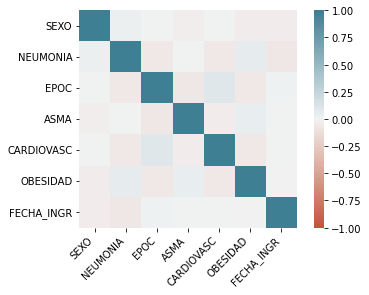

In [11]:
X = db[sel_vars[:-1]]
ax = sns.heatmap(X.corr(), vmin=-1, vmax=1, center=0,
                 cmap=sns.diverging_palette(20, 220, n=200),square=True)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,horizontalalignment='right');

In [12]:
db.groupby('VIVE').count().iloc[:,0]

VIVE
0      280
1    25366
Name: Unnamed: 0, dtype: int64

We can note the independent variable is very unbalanced (with a ration of 280:25366), this is important due the learning contribution from each class may affect the performance classifier, in other words the classifier will become more efficient in detecting the class 1 (ALIVE) than detecting the class 0 (DEAD).The implemented algorithm is executed with the following parameters
- data_set = db_covid.csv
- max_degree=81
- population_size=36
- generations=10
- crossover_probability=0.9
- mutation_probability=0.05
- cost_function='rms'

/home/bandala/Dropbox/PCIC/Segundo semestre/Computación evolutiva/genetic_algorithm/fast_ascent_algorithm_njit.py:184: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 1d, C))
  y_i = np.dot(comb_matrix,solution_coef)


Genetic algorithm starting...
Generation  1  -> Error RMS:  0.48529719583306913  	 | 	 Minimax error:  1.0  	 | 	 Elapsed time:  0.12  min
Generation  10  -> Error RMS:  0.16877564365956402  	 | 	 Minimax error:  1.0  	 | 	 Elapsed time:  0.4  min
Generation  20  -> Error RMS:  0.15105995485644294  	 | 	 Minimax error:  1.0  	 | 	 Elapsed time:  0.79  min
Generation  30  -> Error RMS:  0.1464995045014937  	 | 	 Minimax error:  1.0  	 | 	 Elapsed time:  1.03  min
Generation  40  -> Error RMS:  0.13752124624717985  	 | 	 Minimax error:  1.0  	 | 	 Elapsed time:  1.53  min
Generation  50  -> Error RMS:  0.13855012198242947  	 | 	 Minimax error:  1.0  	 | 	 Elapsed time:  2.35  min
Generation  60  -> Error RMS:  0.1387579906743223  	 | 	 Minimax error:  1.0  	 | 	 Elapsed time:  2.31  min
Generation  70  -> Error RMS:  0.1374163213265119  	 | 	 Minimax error:  1.0  	 | 	 Elapsed time:  2.41  min
Generation  80  -> Error RMS:  0.13742715860053925  	 | 	 Minimax error:  1.0  	 | 	 Elapsed ti

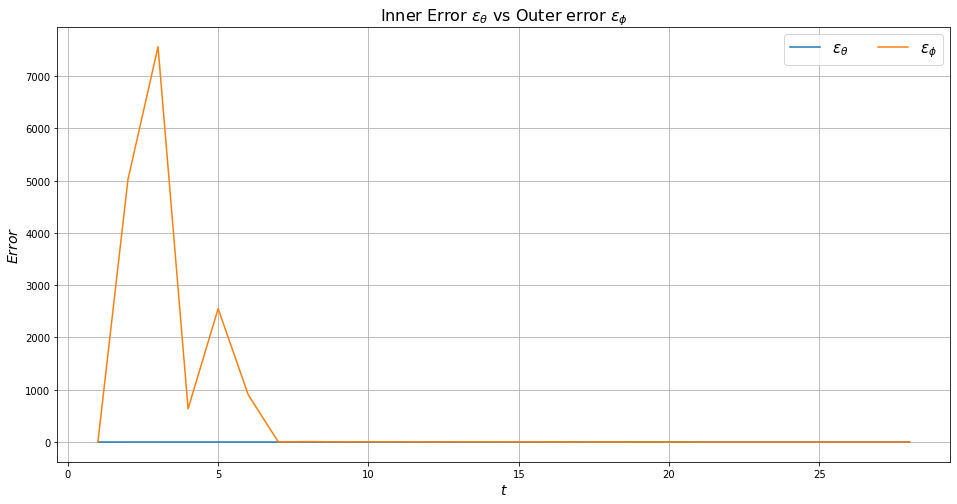

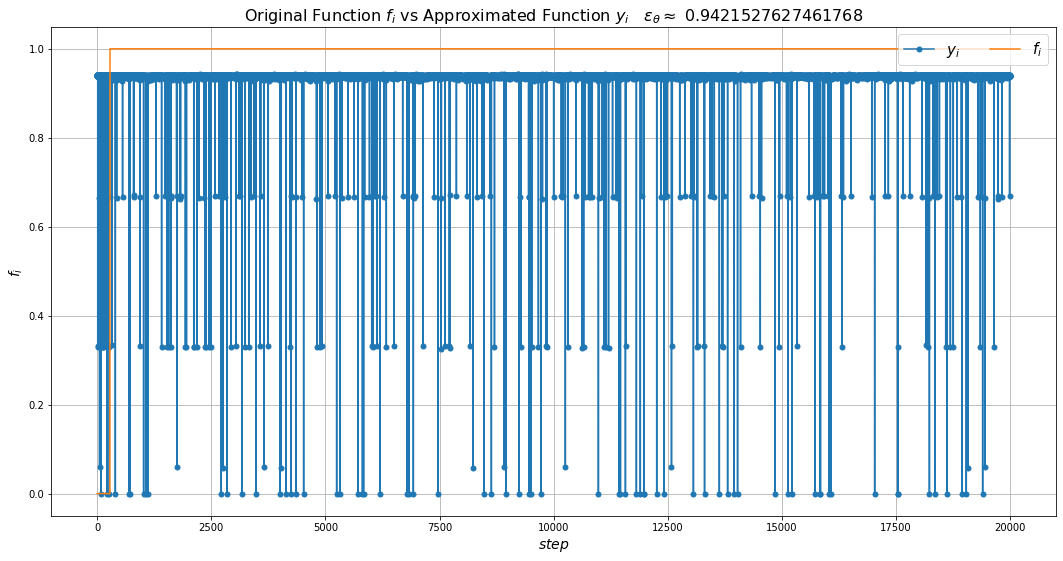


*** RESULTS ***
E_minimax: 	0.9421527627 
C[ 1]	 7.2548896166 
C[ 2]	 0.0559236907 
C[ 3]	 997406.5638004246 
C[ 4]	 0.0769739603 
C[ 5]	 -12.7227608256 
C[ 6]	 -0.0423359994 
C[ 7]	 -248.3918915495 
C[ 8]	 95619.0764122909 
C[ 9]	 -5336.6356008896 

EGA Performance Metrics
Train error (RMS) 0.13784132694035303  	 | 	 Test error (RMS):  0.08167440932601212
Train error (Minimax) 1.0  	 | 	 Test error (Minimax):  1.0


In [13]:
# trigger algorithm
mon_degrees,mon_coeffs,rms_errors,mnmx_errors = EGA("dbcovidcesamo/db_covid.csv",selected_cols=sel_vars,generations=100)

## Approximated function
According with the previous variable definition we have obtained the following polynomial, with 9 terms, for the covid dataset
$$P_c(V_1,V_2,V_3,V_4,V_5,V_6,V_7) = 3.855718V_4 -0.00060650V_3^9V_7^2 + 1.18835e+06V_2^2V_3V_5^2 + 39.825533V_1 -1.518942V_3^4V_6^7 + 0.000204V_3^3V_7^8 + 95110.3957V_3^33 - 6361.80653V_2 -229.589707 $$

In [20]:
print('Monomials variables powers: \n',mon_degrees)

Monomials variables powers: 
 [[ 0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  9.  0.  0.  0.  2.]
 [ 0.  2.  1.  0.  2.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  4.  0.  0.  7.  0.]
 [ 0.  0.  3.  0.  0.  0.  8.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. 33.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.]]


In [21]:
print('Monomials coefficients: \n',mon_coeffs)

Monomials coefficients: 
 [ 3.85571828e+00 -6.06503553e-04  1.18835165e+06  3.98255339e+01
 -1.51894260e+00  2.04728404e-04 -2.29589707e+02  9.51103957e+04
 -6.36180653e+03]


Lastly, we plot the training RMS error along each generations. The genetic algorithm optimize the polynomials approximation error and it is remarkable that above the 30th generation the algorithm is no longer capable of minimizing the RMS error, this error stabilizes around 0.13 value on training dataset but we obtain a better performance on validation set, wich RMS error is around 0.08.

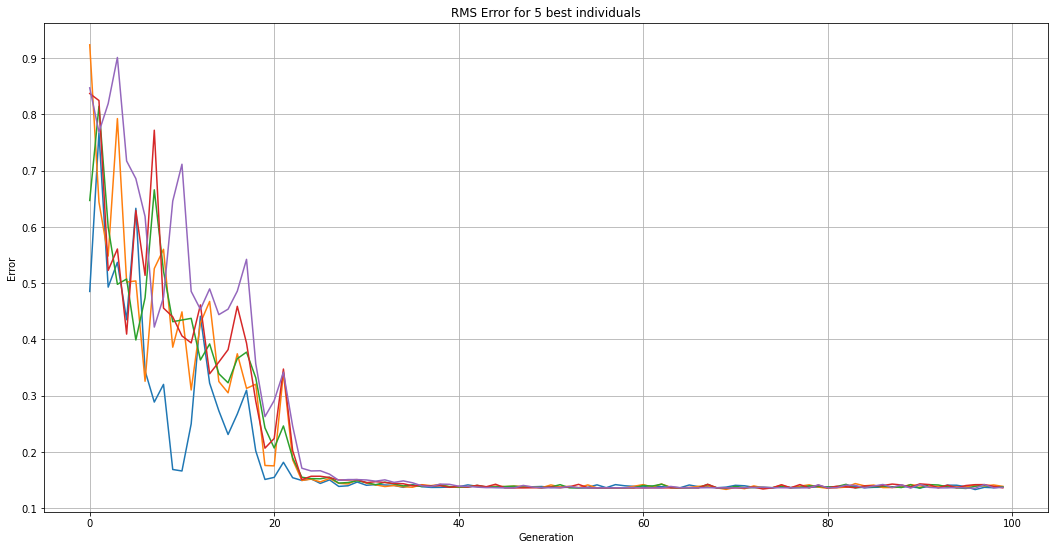

In [16]:
plt.figure(figsize=(18,9))
plt.plot(rms_errors)
plt.title("RMS Error for 5 best individuals")
plt.ylabel("Error")
plt.xlabel("Generation")
plt.grid()

And the minimax error too.

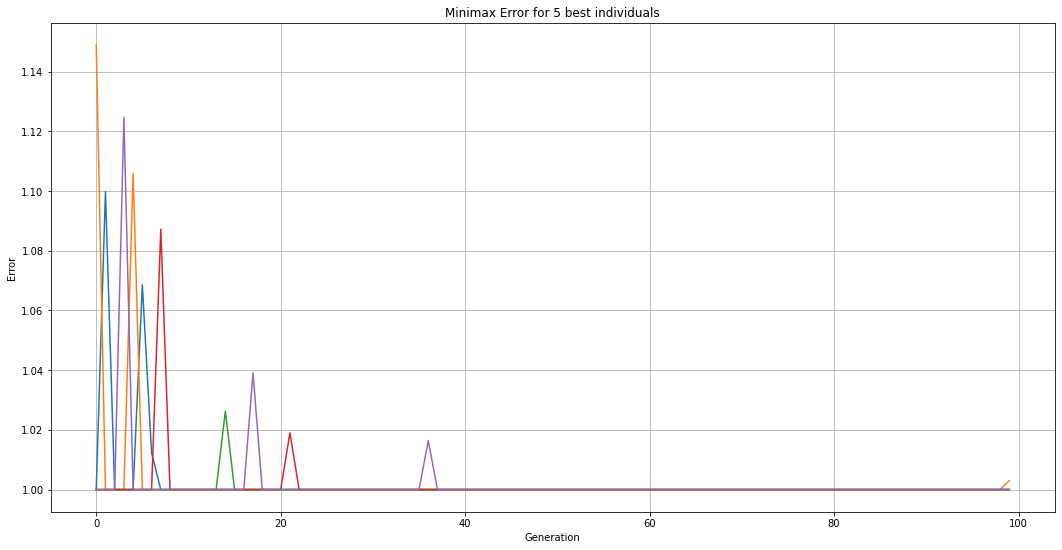

In [17]:
plt.figure(figsize=(18,9))
plt.plot(mnmx_errors)
plt.title("Minimax Error for 5 best individuals")
plt.ylabel("Error")
plt.xlabel("Generation")
plt.grid()